In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
import joblib

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer

import xgboost as xgb

%matplotlib inline

In [9]:
BTC_BUSD = pd.read_parquet("../Data/BTC-BUSD.parquet")
BTC_BUSD.tail(5)

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2022-02-06 23:55:00,42442.679688,42442.679688,42378.761719,42386.289062,17.05913,723546.687500,356,6.56828,278577.156250
2022-02-06 23:56:00,42395.570312,42413.828125,42360.000000,42409.789062,19.49424,826233.937500,446,7.16173,303548.687500
2022-02-06 23:57:00,42409.781250,42444.441406,42409.781250,42436.199219,3.18797,135266.046875,157,1.84208,78158.585938
2022-02-06 23:58:00,42436.199219,42459.179688,42415.078125,42416.441406,4.94982,210047.859375,238,1.92365,81637.390625
2022-02-06 23:59:00,42416.441406,42436.289062,42385.269531,42403.871094,5.26714,223397.812500,256,2.15756,91516.570312


In [10]:
# Check if there is any NaN values
for col_name, _ in BTC_BUSD.iteritems():
    if len(BTC_BUSD[BTC_BUSD[col_name].isna()])>0:
        print("%s: %s rows" % (col_name, len(BTC_BUSD[BTC_BUSD[col_name].isna()])))

In [11]:
# Data clean and related analysis
BTC_BUSD_copy = BTC_BUSD.copy()
BTC_BUSD_copy.reset_index(drop=False, inplace=True)

Text(0, 0.5, 'BTC-BUSD open price')

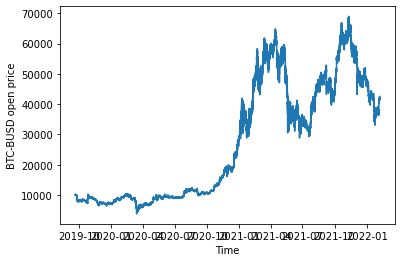

In [12]:
plt.plot(BTC_BUSD_copy['open_time'], BTC_BUSD_copy['open'])
plt.xlabel('Time')
plt.ylabel('BTC-BUSD open price')

In [13]:
# Set predict time (e.g. m=5 represents "5 minutes later")
m = 5

In [14]:
# Option1: use price m minutes later
# Set target price (m minutes later)
target_price = BTC_BUSD_copy['open'].shift(-m, fill_value=BTC_BUSD_copy['open'].iloc[-1]).rename("price_m_min_later")

# Option2: use price difference between current price and price m minute later
# Set target price difference(m minutes later diff)
target_price_diff = (target_price - BTC_BUSD_copy['open']).rename("price_diff_m_min_later")

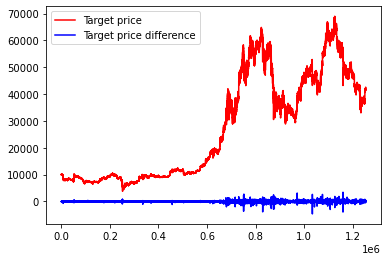

In [17]:
plt.plot(target_price, 'r', label='Target price')
plt.plot(target_price_diff, 'b', label='Target price difference')
plt.legend()

In [20]:
dataset = pd.concat([BTC_BUSD_copy, target_price, target_price_diff], axis=1)
dataset.head()

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,price_m_min_later,price_diff_m_min_later
0,2019-09-19 10:02:00,9881.429688,9881.429688,9881.429688,9881.429688,0.001113,10.998032,1,0.001113,10.998032,9878.360352,-3.069336
1,2019-09-19 10:03:00,9881.429688,9881.429688,9881.429688,9881.429688,0.000000,0.000000,0,0.000000,0.000000,9878.360352,-3.069336
2,2019-09-19 10:04:00,9878.360352,9878.360352,9878.360352,9878.360352,0.012940,127.825981,1,0.012940,127.825981,9878.360352,0.000000
3,2019-09-19 10:05:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000,9878.360352,0.000000
4,2019-09-19 10:06:00,9878.360352,9878.360352,9878.360352,9878.360352,0.000000,0.000000,0,0.000000,0.000000,9878.360352,0.000000


In [21]:
class XGBoost_model():
    def __init__(self, **kwargs):
        self.objective = kwargs.get('objective', 'reg:squarederror')
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.max_depth = kwargs.get('max_depth', 3)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.booster = kwargs.get('booster', 'gbtree')
        self.gamma = kwargs.get('gamma', 0)
        self.reg_alpha = kwargs.get('reg_alpha', 0)
        self.reg_lambda = kwargs.get('reg_lambda', 1)

    def opt_hyper_grid(self, x, y, param_space, num_sets: int=5):

        print('Finding best hyper-parameters for the model...')
        estimator = xgb.XGBRegressor(objective=self.objective, max_depth=self.max_depth,
                                     learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                     subsample=self.subsample, booster=self.booster, n_jobs=-1, gamma=self.gamma,
                                     reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda)
        xgb_try = GridSearchCV(estimator=estimator, param_grid=param_space, cv=KFold(n_splits=num_sets, shuffle=True), scoring='neg_mean_absolute_error')
        grid_result = xgb_try.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']
        
        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = xgb_try.best_params_
        print('Best params set:', best_params)
        print('Minimum mean absolute error:', -np.max(means))
        print('---------------------------------------------------')
        
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.subsample = best_params.get('subsample', self.subsample)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.booster = best_params.get('booster', self.booster)
        self.gamma = best_params.get('gamma', self.gamma)
        self.reg_alpha = best_params.get('reg_alpha', self.reg_alpha)
        self.reg_lambda = best_params.get('alpha', self.reg_lambda)

        return 


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.subsample = params.get('subsample', self.subsample)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.booster = params.get('booster', self.booster)
            self.gamma = params.get('gamma', self.gamma)
            self.reg_alpha = params.get('reg_alpha', self.reg_alpha)
            self.reg_lambda = params.get('alpha', self.reg_lambda)

        xgb_reg = xgb.XGBRegressor(objective=self.objective, max_depth=self.max_depth,
                                   learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                   subsample=self.subsample, booster=self.booster, gamma=self.gamma,
                                   n_jobs=-1, reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda)
        # 10 fold cross-validation
        sk = KFold(n_splits=5, shuffle=True)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            xgb_reg.fit(train_x, train_y)
            pred_train_xgb = xgb_reg.predict(train_x)
            pred_val_xgb = xgb_reg.predict(val_x)

            score_train = mean_absolute_error(train_y, pred_train_xgb)
            scores_train.append(score_train)
            score_val = mean_absolute_error(val_y, pred_val_xgb)
            scores_val.append(score_val)

        print('Train mean absolute error:', np.mean(scores_train))
        print('Val mean absolute error:', np.mean(scores_val))

        return xgb_reg


    def save_model(self, model):

        print('Saving model...')
        folder_path = os.getcwd()
        model_path = folder_path + '\\xgboost_model.pkl'
        joblib.dump(model, model_path)
        print('Model saved.')

    def predict_with_model(self, model, x_test):
        y_test_pred = model.predict(x_test)

        return y_test_pred

In [34]:
# Set starting point & train length
N = len(dataset)
start_point = int(0.47*N)
train_length = 15 * 24 * 60
# Set test length
test_length = 24 * 60


X_train = dataset.iloc[start_point : start_point + train_length, 1:-2]
X_test = dataset.iloc[start_point + train_length : start_point + train_length + test_length , 1:-2]

# Use price difference as the target
Y_train = dataset.iloc[start_point : start_point + train_length, -1]
Y_test = dataset.iloc[start_point + train_length : start_point + train_length + test_length , -1]
    
print("Train range: ", start_point, " - ", start_point + train_length)
print("Train length:", train_length)
print('='*20)
print("Test range: ", start_point + train_length, " - ", start_point + train_length + test_length)
print("Test length:", test_length)

Train range:  588704  -  610304
Train length: 21600
Test range:  610304  -  611744
Test length: 1440


# _Price or price difference?_

## Predict price difference

In [24]:
# Determine if grid search is necessary
grid_search = False


# With hyperparameter grid search
if grid_search:
    task = XGBoost_model()

    params = {'learning_rate': [0.03, 0.1, 0.3],
                   'n_estimators': [100, 200]

    }

    xgb_reg = task.build_model(X_train, Y_train, params, grid_search=True)
    # mymodel.save_model(gbdt_reg)
    Y_test_pred = task.predict_with_model(xgb_reg, X_test)
    print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))
    
# Without hyperparameter grid search
else:
    task = XGBoost_model()

    params = {'learning_rate': 0.1,
                   'n_estimators': 300

    }
    xgb_reg = task.build_model(X_train, Y_train, params, grid_search=False)

    Y_test_pred = task.predict_with_model(xgb_reg, X_test)
    print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

Train mean absolute error: 18.590496
Val mean absolute error: 19.883938
Test mean absolute error: 29.991438


In [25]:
# If use price difference, the predicted price is calculated as

Y_train_price = Y_train + dataset['open'].iloc[start_point : start_point + train_length].values
Y_test_price = Y_test + dataset['open'].iloc[start_point + train_length : start_point + train_length + test_length].values
Y_pred_test_price = Y_test_pred + dataset['open'].iloc[start_point + train_length : start_point + train_length + test_length].values


## Predict price

In [26]:
X_train_pp = dataset.iloc[start_point : start_point + train_length, 1:-2]
X_test_pp = dataset.iloc[start_point + train_length : start_point + train_length + test_length , 1:-2]

# Use future price as the target
Y_train_pp = dataset.iloc[start_point : start_point + train_length, -2]
Y_test_pp = dataset.iloc[start_point + train_length : start_point + train_length + test_length , -2]
    
print("Train range: ", start_point, " - ", start_point + train_length)
print("Train length:", train_length)
print('='*20)
print("Test range: ", start_point + train_length, " - ", start_point + train_length + test_length)
print("Test length:", test_length)

Train range:  588704  -  610304
Train length: 21600
Test range:  610304  -  611744
Test length: 1440


In [27]:
# Determine if grid search is necessary
grid_search = False


# With hyperparameter grid search
if grid_search:
    task = XGBoost_model()

    params = {'learning_rate': [0.03, 0.1, 0.3],
                   'n_estimators': [100, 200]

    }

    xgb_reg_pp = task.build_model(X_train_pp, Y_train_pp, params, grid_search=True)
    # mymodel.save_model(gbdt_reg)
    Y_test_pred_pp = task.predict_with_model(xgb_reg_pp, X_test_pp)
    print("Test mean absolute error: %f" % (mean_absolute_error(Y_test_pp, Y_test_pred_pp)))
    
# Without hyperparameter grid search
else:
    task = XGBoost_model()

    params = {'learning_rate': 0.1,
                   'n_estimators': 300

    }
    xgb_reg_pp = task.build_model(X_train_pp, Y_train_pp, params, grid_search=False)

    Y_test_pred_pp = task.predict_with_model(xgb_reg_pp, X_test_pp)
    print("Test mean absolute error: %f" % (mean_absolute_error(Y_test_pp, Y_test_pred_pp)))

Train mean absolute error: 17.900995
Val mean absolute error: 19.801554
Test mean absolute error: 363.624084


In [28]:
Y_train_price_pp = Y_train_pp + dataset['open'].iloc[start_point : start_point + train_length].values
Y_test_price_pp = Y_test_pp
Y_pred_test_price_pp = Y_test_pred_pp

Text(0.5, 1.0, 'Close price pridiction - gbdt')

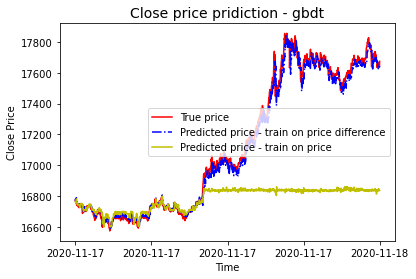

In [31]:
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], 
         Y_test_price, 'r', label="True price")
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], 
         Y_pred_test_price, 'b-.', label="Predicted price - train on price difference")
plt.plot(dataset['open_time'][start_point + train_length : start_point + train_length + test_length], 
         Y_pred_test_price_pp, 'y-', label="Predicted price - train on price")
plt.xticks([dataset.iloc[i]['open_time'] for i in np.linspace(start_point + train_length, start_point + train_length + test_length, 5, dtype=int)])
plt.legend()
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.title("Close price pridiction - gbdt",fontsize=14)

# _gbdt v.s. xgboost_

In [35]:
# gbdt full parameters - no shuffling
t1_Train_score = [17.805290270759134, 18.379185561149434, 17.293686326992695, 16.4202213649655, 16.87936504501488, 17.11936390288815, 17.13159996150357, 17.322029817496762, 17.67199706459243, 18.392274665512495]
t1_Validation_score = [14.290602227483948, 9.167340609536005, 18.829535402271848, 27.188301114593767, 22.75970677443971, 20.457462640153917, 20.599341445279727, 18.690057121991625, 15.657878153858027, 9.050566205849586]

t2_Train_score = [25.467254684198593, 26.28514367614549, 24.700736959755755, 23.39162026630151, 24.212575374221192, 24.507632211029527, 24.546608089339088, 24.877800870019556, 25.369525608542727, 26.411167939689815]
t2_Validation_score = [20.918643948549757, 13.558060096222816, 27.59144039693393, 40.02076380626079, 32.219273520498795, 29.701578571524596, 29.229796813983683, 26.212561490418004, 21.646521493984082, 12.437239834553584]

t3_Train_score = [30.79298595212619, 31.766970571263556, 29.911383834503575, 28.319357211590617, 29.305821883522952, 29.681093717888082, 29.696790382234745, 30.1228938323383, 30.734775533406935, 31.958203927431757]
t3_Validation_score = [25.53271535660534, 16.740160892018906, 33.421160623199185, 48.24968866175014, 39.182400825891555, 35.741621067855284, 35.491648405712255, 31.31720973597297, 26.270771026915227, 15.121820798200993]

t4_Train_score = [35.43898836348465, 36.54365731249953, 34.45951242488733, 32.568003105677256, 33.74495016722576, 34.30634354452297, 34.18564711810753, 34.73577356634196, 35.36453139206148, 36.80224904071672]
t4_Validation_score = [29.53277130653408, 19.67965465702506, 38.350953812288, 55.65519683975118, 45.1953407989759, 40.25752598725475, 41.05544793057274, 36.18589267958109, 30.600372946255188, 17.479087817007517]

t5_Train_score = [39.78881537412027, 40.90901891875318, 38.56080563896668, 36.48034429309883, 37.79795711419382, 38.339665712579695, 38.31534469918995, 38.834762860964915, 39.69583774935803, 41.26917011135846]
t5_Validation_score = [32.39868152403136, 22.39363801854037, 43.62172192901327, 62.25708462183725, 50.85685935191147, 45.6334644023612, 46.044518477309026, 40.85904307250879, 33.89682366219733, 19.40146969145099]

train_scores = [t1_Train_score, t2_Train_score, t3_Train_score, t4_Train_score, t5_Train_score]
val_scores = [t1_Validation_score, t2_Validation_score, t3_Validation_score, t4_Validation_score, t5_Validation_score]
gbdt_ns_train, gbdt_ns_val = [], []
for i in range(len(train_scores)):
    gbdt_ns_train.append(np.average(train_scores[i]))
    gbdt_ns_val.append(np.average(val_scores[i]))

gbdt_ns_train

[17.441501398087507,
 24.977006567924327,
 30.229027684630672,
 34.81496560355252,
 38.999172247258386]

In [37]:
# gbdt full parameters - shuffling
t1_Train_score = [17.444384440482523, 17.526257316813272, 17.3916212393581, 17.39748443810559, 17.411398414271613, 17.470714493195903, 17.361424403200058, 17.50448740286542, 17.48257258538246, 17.445038163275168]
t1_Validation_score = [17.639171524582046, 17.15530236813285, 17.987511679719358, 18.22002385226149, 17.9289061287656, 17.441812157395063, 18.1688781442714, 17.06508566863696, 17.556718108724585, 17.701164955496168]

t2_Train_score = [25.002566544068085, 24.89626038213549, 25.07331915773039, 25.084590704961908, 24.863168606219254, 25.100437522075616, 24.991883757880693, 24.787763591907492, 24.953307082080933, 24.992115334748295]
t2_Validation_score = [25.168809481606857, 25.869619917620394, 24.790235737598135, 24.297726454956383, 26.462112092839096, 24.06584665856311, 25.081524245999876, 26.55654081350794, 25.468094947048844, 25.338616348671533]

t3_Train_score = [30.289433342705262, 30.180501636967577, 30.347352563556047, 30.158054243320617, 30.31184543620325, 30.154565914222506, 30.152802112215756, 30.171934780471872, 30.39409388574133, 30.186314423810465]
t3_Validation_score = [30.172917022701352, 31.22066024843225, 29.56408269479043, 30.998574397698018, 29.955090610736324, 31.26243217150377, 31.110438507754747, 31.383463798538656, 29.084840865056574, 31.085233714317233]

t4_Train_score = [35.003138126235754, 34.81267142443905, 34.8589104820293, 34.854118837575804, 34.79473084167479, 34.91593750044635, 34.685820285617595, 34.89421064870406, 34.63915545285874, 34.71344085703191]
t4_Validation_score = [33.56052705338072, 34.87128469196933, 35.280065068476674, 34.960283106924514, 35.27661770421157, 34.48365001709885, 36.46438558079331, 34.43398571894164, 36.86253849007233, 36.100174717125775]

t5_Train_score = [39.140961961179734, 38.71183958782419, 38.729868534973036, 38.695613729642176, 38.601429205530366, 38.819844963254795, 38.92406783523487, 38.72822566595481, 38.770178333562555, 38.63457763228666]
t5_Validation_score = [36.24700605917751, 40.21140068550812, 39.74049474760648, 40.27549509059806, 40.88651770320977, 39.07451697592824, 38.192777969876865, 39.896564341232484, 39.457246537271566, 40.43478158265883]

train_scores = [t1_Train_score, t2_Train_score, t3_Train_score, t4_Train_score, t5_Train_score]
val_scores = [t1_Validation_score, t2_Validation_score, t3_Validation_score, t4_Validation_score, t5_Validation_score]
gbdt_train, gbdt_val = [], []
for i in range(len(train_scores)):
    gbdt_train.append(np.average(train_scores[i]))
    gbdt_val.append(np.average(val_scores[i]))

gbdt_train

[17.44353828969501,
 24.974541268380815,
 30.234689833921472,
 34.81721344566134,
 38.77566074494432]

In [38]:
# Xgboost full parameters - no shuffling

t1_Train_score = [17.76143977803786, 18.337775391634093, 17.265706648468026, 16.364502469307027, 16.838770786125817, 17.07498364312839, 17.08849879177304, 17.271456985178954, 17.63415964549872, 18.34934768664688]
t1_Validation_score = [14.285666692251517, 9.149148403606636, 18.85161108485611, 27.181571813886904, 22.69734862475242, 20.395660872340258, 20.54150400918939, 18.6758931026187, 15.656369775987153, 9.054942149625434]

t2_Train_score = [25.3599489143146, 26.19627881535138, 24.636537404207683, 23.338077923188788, 24.16613073093518, 24.461499232124623, 24.457344509769584, 24.798723405096727, 25.3100895583383, 26.332274900941535]
t2_Validation_score = [20.90457700580895, 13.553078464922205, 27.644289570651843, 39.95160116396301, 32.23924683882328, 29.622174935975988, 29.169213667738944, 26.225359911610656, 21.658180526420104, 12.436901641347013]

t3_Train_score = [30.687220715761804, 31.68035156239618, 29.840333752375457, 28.20102307196061, 29.246627033176235, 29.651964635839043, 29.622170402639092, 30.023517114187857, 30.635821955679468, 31.86269619697057]
t3_Validation_score = [25.48592800582575, 16.724075712353066, 33.422213422381645, 48.24575301081701, 39.349386109765106, 35.677857407203085, 35.453679921661724, 31.347892283996757, 26.22716989963901, 15.115116751237272]

t4_Train_score = [35.358492075956825, 36.45581231783033, 34.42525538762029, 32.439692334368054, 33.716036386102324, 34.26813823224678, 34.08916546827393, 34.64207126021069, 35.3198319602992, 36.71997195729599]
t4_Validation_score = [29.540181105545102, 19.673871260815346, 38.323807499589776, 55.841852844090724, 45.20638409648584, 40.24365948002002, 41.11457390234591, 36.1284315643755, 30.56249264644337, 17.489021907954804]

t5_Train_score = [39.78881537412027, 40.90901891875318, 38.56080563896668, 36.48034429309883, 37.79795711419382, 38.339665712579695, 38.31534469918995, 38.834762860964915, 39.69583774935803, 41.26917011135846]
t5_Validation_score = [32.39868152403136, 22.39363801854037, 43.62172192901327, 62.25708462183725, 50.85685935191147, 45.6334644023612, 46.044518477309026, 40.85904307250879, 33.89682366219733, 19.40146969145099]

train_scores = [t1_Train_score, t2_Train_score, t3_Train_score, t4_Train_score, t5_Train_score]
val_scores = [t1_Validation_score, t2_Validation_score, t3_Validation_score, t4_Validation_score, t5_Validation_score]
xgboost_ns_train, xgboost_ns_val = [], []
for i in range(len(train_scores)):
    xgboost_ns_train.append(np.average(train_scores[i]))
    xgboost_ns_val.append(np.average(val_scores[i]))

xgboost_ns_train

[17.398664182579882,
 24.90569053942684,
 30.14517264409863,
 34.74344673802044,
 38.999172247258386]

In [39]:
# Xgboost full parameters - shuffling


t1_Train_score =[17.410168268404245, 17.37196120779923, 17.40249368379176, 17.423355797896946, 17.447033111468052, 17.371008769766057, 17.352672406608782, 17.36362444271966, 17.4067491096976, 17.43514676069712]
t1_Validation_score = [17.516121257878037, 17.77992766416702, 17.85972691520508, 17.413903603173146, 17.395121738025317, 17.951283562115933, 18.126354530133334, 17.92899301268902, 17.417998923702132, 17.325463040000336]

t2_Train_score = [24.893620517597114, 25.011859042571757, 24.842318224477754, 24.855390881088617, 24.962247471049054, 24.992350354897674, 24.77301743592327, 24.89330960588799, 24.848623457015673, 24.90306618193582]
t2_Validation_score = [25.214116952008947, 24.419809257572414, 25.796987845505512, 25.517249152568592, 24.617294801581732, 24.452168755414572, 26.381304130303217, 25.669078081643026, 25.302929210415446, 25.244576977999696]

t3_Train_score = [29.85165718891241, 29.736196329641405, 29.891275053663307, 29.82957346042548, 29.712380433148223, 30.02741255981109, 29.88476499880229, 29.898818377224146, 29.701700126395426, 29.88281229787241]
t3_Validation_score = [30.44676123301733, 31.44605243140926, 29.782742980286606, 30.668718656833562, 31.808165085756475, 29.479095500198117, 29.95528642735474, 30.476832623280053, 31.91690961157788, 30.311244121647448]

t4_Train_score = [34.454786665864496, 34.7418143680243, 34.6229169292269, 34.828300212799654, 34.8022855835901, 34.991088297748156, 34.654053754336395, 34.51951445441206, 35.028615549241046, 34.80491443846982]
t4_Validation_score = [37.47424768184685, 35.178489691485595, 36.143043960340705, 34.581000501431234, 34.62131783028727, 33.02994086762652, 35.6948706038974, 37.51830186068157, 32.99260405620179, 34.62499803992955]

t5_Train_score = [37.93638028596188, 38.44443927324168, 37.85026174080878, 38.03036024742461, 37.80044749549525, 37.99267693231065, 37.884898700339306, 37.91868863071981, 38.00347906869904, 38.04612087987284]
t5_Validation_score = [40.12061044783103, 35.373240322914896, 40.68859892351023, 39.34008471794515, 40.293715968855835, 39.58600585585077, 39.53124225842271, 39.972109532268924, 39.13139800877349, 39.33410665648477]


train_scores = [t1_Train_score, t2_Train_score, t3_Train_score, t4_Train_score, t5_Train_score]
val_scores = [t1_Validation_score, t2_Validation_score, t3_Validation_score, t4_Validation_score, t5_Validation_score]
xgboost_train, xgboost_val = [], []
for i in range(len(train_scores)):
    xgboost_train.append(np.average(train_scores[i]))
    xgboost_val.append(np.average(val_scores[i]))

xgboost_train

[17.398421355884945,
 24.897580317244472,
 29.841659082589622,
 34.744829025371295,
 37.990775325487384]

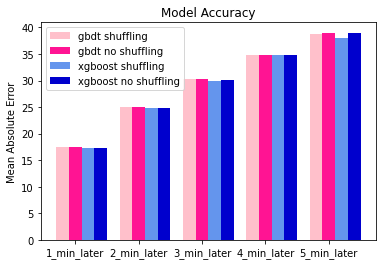

In [40]:
name_list = ["1_min_later", "2_min_later", "3_min_later", "4_min_later", "5_min_later"]

x =list(range(len(gbdt_train)))
total_width, n = 0.8, 4
width = total_width / n
 
plt.bar(x, gbdt_train, width=width, label='gbdt shuffling', fc = "#FFC0CB")
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, gbdt_ns_train, width=width, label='gbdt no shuffling', tick_label = name_list, fc = "#FF1493")
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, xgboost_train, width=width, label='xgboost shuffling',fc = "#6495ED")
for i in range(len(x)):
    x[i] = x[i] + width
plt.bar(x, xgboost_ns_train, width=width, label='xgboost no shuffling', fc = "#0000CD")
plt.ylabel("Mean Absolute Error")
plt.title("Model Accuracy")
plt.legend()
plt.show()

# _Twitter data?_

In [49]:
BTC_BUSD = pd.read_csv("../Data/BTC2.csv")
BTC_BUSD_copy = BTC_BUSD.copy()
BTC_BUSD_copy.reset_index(drop=True, inplace=True)

BTC_BUSD_copy2 = BTC_BUSD.copy().drop(labels=['avg','wgtavg'],axis=1)
BTC_BUSD_copy2.reset_index(drop=True, inplace=True)

In [46]:
# Load saved models
m_min, m_max = 1, 5
gbdt_models = []
for m in range(m_min, m_max+1):
    load_path = "Models/gbdt_" + str(m) + "_minutes_later.pkl"
    if os.path.exists(load_path):
        gbdt_models.append(joblib.load(load_path))
    else:
        print("Warning: model %d does not found." % (m))

gbdt_models_nt = []
for m in range(m_min, m_max+1):
    load_path = "Models/gbdt_" + str(m) + "_minutes_later_no_twitter_try.pkl"
    if os.path.exists(load_path):
        gbdt_models_nt.append(joblib.load(load_path))
    else:
        print("Warning: model %d does not found." % (m))

In [54]:
N = len(BTC_BUSD_copy)
st_point = 10200
pred_length = 300

for i in range(len(s_points)-1):
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    price_pred_all = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (gbdt_models[j].predict(BTC_BUSD_copy.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred_all.append(cur_sum / cur_portion if cur_portion !=0 else 0)

for i in range(len(s_points)-1):
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    price_pred2_all = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (gbdt_models_nt[j].predict(BTC_BUSD_copy2.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy2.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred2_all.append(cur_sum / cur_portion if cur_portion !=0 else 0)

In [55]:
price_true_all = BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['close'].values

Text(0, 0.5, 'Close Price')

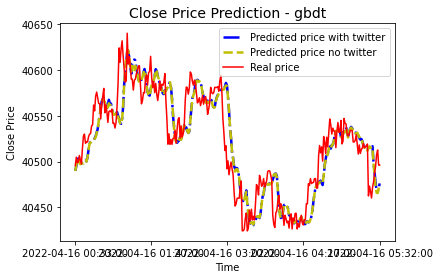

In [57]:
plt.figure()
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], 
         price_pred_all,'b-.', linewidth=2.5,label='Predicted price with twitter')
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], 
         price_pred2_all,'y--', linewidth=2.5,label='Predicted price no twitter')
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], 
         price_true_all, 'r', label="Real price")
plt.xticks([BTC_BUSD_copy2.iloc[i]['open_time'] for i in np.linspace(st_point, st_point+pred_length-1, 5, dtype=int)])
plt.legend()
plt.title("Close Price Prediction - gbdt", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Close Price")

In [52]:
# With twitter data
N = len(BTC_BUSD_copy)
s_points = np.linspace(0, N, 11, dtype=int)

mae_error_list, mape_error_list = [], []
for i in range(len(s_points)-1):
    st_point = s_points[i]
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    pred_length = s_points[i+1] - s_points[i]
    price_pred = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (gbdt_models[j].predict(BTC_BUSD_copy.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred.append(cur_sum / cur_portion if cur_portion !=0 else 0)

    price_true = BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['close'].values
    mae_error_list.append(mean_absolute_error(price_true, price_pred))
    mape_error_list.append(mean_absolute_percentage_error(price_true, price_pred))
print("MAE: ", mae_error_list)
print("MAPE: ", mape_error_list)

MAE:  [44.22770881429972, 24.3926140898651, 46.623231062481125, 65.49519065272138, 52.513553994238464, 49.194332374394776, 47.39944757797716, 43.75811254295898, 35.78723113364603, 19.865339125160624]
MAPE:  [0.0010432416500189019, 0.0005721012896751488, 0.0010957264040312713, 0.0016108771100054927, 0.0013121454171148405, 0.00123365168821436, 0.001156086787283365, 0.0010831830410470676, 0.0008890360798509323, 0.000491114675716053]


In [53]:
# Without twitter data
N = len(BTC_BUSD_copy2)
s_points = np.linspace(0, N, 11, dtype=int)

mae_error_list, mape_error_list = [], []
for i in range(len(s_points)-1):
    st_point = s_points[i]
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    pred_length = s_points[i+1] - s_points[i]
    price_pred2 = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (gbdt_models_nt[j].predict(BTC_BUSD_copy2.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy2.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred2.append(cur_sum / cur_portion if cur_portion !=0 else 0)

    price_true = BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['close'].values
    mae_error_list.append(mean_absolute_error(price_true, price_pred2))
    mape_error_list.append(mean_absolute_percentage_error(price_true, price_pred2))
print("MAE: ", mae_error_list)
print("MAPE: ", mape_error_list)

MAE:  [44.08338950351387, 24.283190331533643, 45.37733148872487, 64.00992652057762, 51.4012262431389, 48.021085049873165, 46.69211141744615, 42.9320349822609, 35.1667607762969, 19.728750033518523]
MAPE:  [0.0010398427262132066, 0.0005695395344634807, 0.0010665379092334598, 0.001574153570559623, 0.0012842927063700478, 0.0012041181182409779, 0.001138826610787532, 0.0010627606576343244, 0.0008736496673599315, 0.0004877416480490444]
